## Import the libraries needed.

In [1]:
# the regulars
import pandas as pd
import numpy as np
import plotly.express as px
import osmnx as ox
import matplotlib.pyplot as plt

# to get tweets
import tweepy as tw

# for sentiment analysis
from textblob import TextBlob
import re

# word clouds
from wordcloud import WordCloud, STOPWORDS

## Access the Twitter API.

In [2]:
# your twitter keys/secrets/tokens
consumer_key= 'vThxGPB49NZxJToR7gN9HrVxi'
consumer_secret= 'WcKNEhNFX09kfkSGvWmHpFvGrJV6DPu0VBU5soT5Lzt9IDgKTK'
access_token= '1361462987840622595-UEqj2mIvBW8QJ0PRKMbWncfNjhz1aL'
access_token_secret= 'TR0F8C8JiQRyLvzZLHd7KkyyZX2u4qOuXVBx9pKCLYAPE'

In [3]:
# authenticate thyself with twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [11]:
# search query
searchterm = 'vaccine death'

# filter out retweets (optional of course)
q = searchterm + " -filter:retweets"

# how many?
max_tweets = 500
 
# Creation of query method using parameters
#tweets = tw.Cursor(api.search,q=q,geocode='28.644800,77.216721,50km',tweet_mode='extended').items(max_tweets)

In [12]:
#for index, tweet in enumerate(tweets):
#    print(str(tweet.created_at) + ': ' + tweet.full_text)

In [31]:
# get a 5 colors from sequential color bar
stop_words = [searchterm] + list(STOPWORDS)+["COVID19","Covid","India","vaccine","death"]
sentiment_colors = ox.plot.get_colors(5,cmap='PiYG',return_hex=True)
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())
def find_tweets(q,place,distance='50km',count=500):
    
    #
    # geocode the place to get coordinates
    #
    
    g = ox.geocoder.geocode(place)
    
    # concatenate the results
    geocode = '"'+str(g[0])+','+str(g[1])+','+distance+'"'
    
    #
    # grab the tweets
    #
    
    tweets = tw.Cursor(api.search,
                       q=q+' -filter:retweets', # no retweets
                       geocode=geocode, 
                       tweet_mode='extended').items(count)
    
    #
    # create a dataframe
    #
    
    json_data = [tweet._json for tweet in tweets]
    df = pd.json_normalize(json_data)

    # clean it up
    df = df[['created_at','full_text']]

    # clean the text
    df['clean_text'] = ''
    
    for i, row in df.iterrows():
        clean = clean_tweet(row.full_text)
        df.at[i,'clean_text'] = clean

    #
    # word cloud
    #
    
    # put every tweet in a single variable
    all_text = ' '.join(df['clean_text'])
    
    # Create stop words
    #stop_words = [searchterm] + list(STOPWORDS)
    
    # create the word cloud
    wordcloud = WordCloud(width=1200, 
                          height=800,
                          background_color="white",
                          stopwords=stop_words).generate(all_text)

    # Display the WordCloud                    
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    #
    # sentiment analysis
    #
    
    df['polarity']=''
    
    # add polarity index to each tweet
    for i, row in df.iterrows():
        a = TextBlob(row.full_text)
        df.at[i,'polarity'] = a.polarity
    
    # create a list of our conditions
    conditions = [
        (df['polarity'] < -0.2), # very negative
        (df['polarity'] < 0) & (df['polarity'] >= -0.2),   # negative
        (df['polarity'] == 0),  # neutral
        (df['polarity'] > 0) & (df['polarity'] <= 0.2),    # positive
        (df['polarity'] > 0.2)  # very positive
        ]

    # create a list of the values we want to assign for each condition
    values = [
        'very negative', 
        'negative', 
        'neutral', 
        'positive',
        'very positive'
        ]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['sentiment'] = np.select(conditions, values)

    #
    # Sentiment bar chart
    #
    
    # bar chart
    fig = px.bar(df, 
                 x='sentiment',
                 width=600,
                 title='Sentiment analysis for "'+ q + '"',
                 color='sentiment',
                 category_orders = {'sentiment':['very negative','negative','neutral','positive','very positive']},
                 color_discrete_sequence=sentiment_colors, # use the colors selected in previous cell
                )
    # fig.update_traces(textinfo='value')
    fig.update_traces(marker_line_width=0) # gets rid of horizontal white lines
    fig.show()

    #
    # histogram
    # 
    
    num_bins = 50
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Polarity')
    plt.ylabel('Count')
    plt.title('Histogram of polarity for "' + q + '"')

    plt.axvline(df.polarity.mean(), color='k', linestyle='dashed', linewidth=1)

    min_ylim, max_ylim = plt.ylim()
    plt.text(df.polarity.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.polarity.mean()))

    plt.show()

    #
    # Show top 10 and bottom 10 tweets
    #
    
    top10 = df.sort_values('polarity').head(10)[['clean_text','polarity']]
    bottom10 = df.sort_values('polarity').tail(10)[['clean_text','polarity']]
    
    display('Top 10 negative tweets')
    display(top10)
    
    display('Top 10 positive tweets')
    display(bottom10)
    
    return df
    
    
    

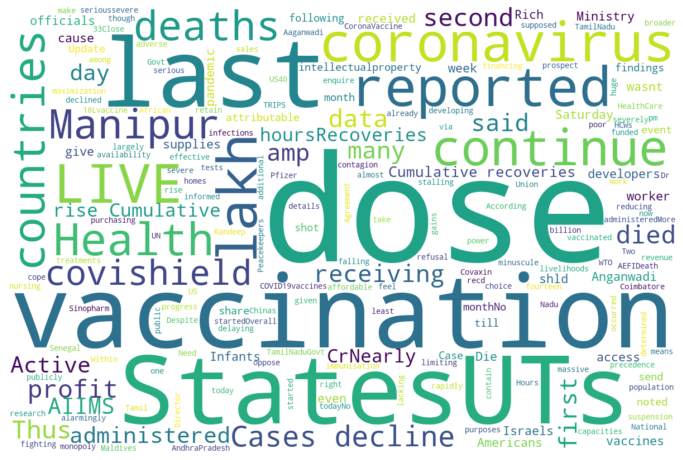

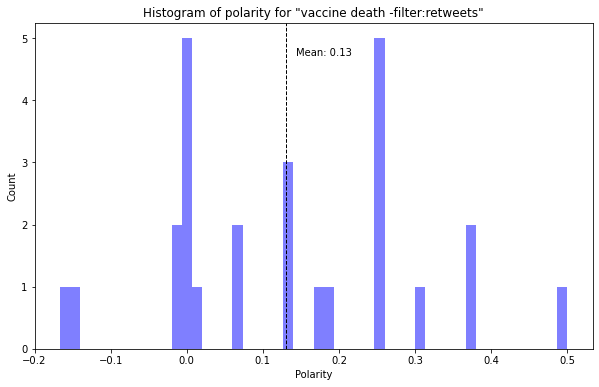

'Top 10 negative tweets'

,clean_text,polarity
13,Over 90 lakh COVID19 vaccine doses have been a...,-0.166667
7,Vaccines have started to work in the US At nur...,-0.15
20,Coronavirus Updates In India Active Cases decl...,-0.008333
24,BREAKING Active Cases decline in all StatesUTs...,-0.008333
23,COVID19India updatesNearly 90 lakh vaccine dos...,0.0
22,CoronaVirusUpdates Active Cases decline in all...,0.0
21,Intern at AIIMS Rishikesh dies 11 days after C...,0.0
9,Two Infants Die Within 24 Hours After Receivin...,0.0
10,CoronaVaccine AndhraPradesh coronavirus,0.0
0,National capacities to cope with the pandemic ...,0.010714


'Top 10 positive tweets'

,clean_text,polarity
19,LIVE Gazas first Covid19 vaccine to ship with ...,0.193182
16,Update on COVID19 Vaccination Day 33Close to 9...,0.25
17,Vaccine developers refusal to share publicly f...,0.25
5,Most deaths after vaccine in India are suppose...,0.25
4,An Anganwadi worker in Manipur died a week aft...,0.25
3,An Anganwadi worker in Manipur died a week aft...,0.25
2,CORONAVIRUS According to data from Israels Hea...,0.3
1,Rich countries continue to oppose the suspensi...,0.375
12,As COVID19 infections and deaths continue to r...,0.375
6,Govt shld give data how many have recd Covaxin...,0.5


In [32]:
df = find_tweets(q,'New Delhi',distance='50km',count=500)